# Start part

### Libs and constants

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, TextVectorization, Embedding, LSTM, Bidirectional
from tensorflow.keras.layers import Layer, MultiHeadAttention, LayerNormalization, GlobalMaxPooling1D, concatenate
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [2]:
BATCH_SIZE = 64

EMBEDDING_DIM = 100
SEQ_LENGTH    = 600
MAX_TOKENS    = 20_000

PATH_DATASET = r"D:\BigDataSets\RNN\IMDB_50k.csv"
PATH_GLOVE   = r"D:\BigDataSets\Vectorization\GloVe\glove.6B.100d.txt"

### Dataset and Tokenizer

In [3]:
def remove_URL(text):  # to remove URLs
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):  # to remove html tags
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

data_frame = pd.read_csv(PATH_DATASET)
data_frame['review'] = data_frame['review'].apply(remove_URL)
data_frame['review'] = data_frame['review'].apply(remove_html)

data = data_frame.to_numpy()
texts, labels = data[:, 0], data[:, 1]
labels[labels=='positive'] = "0"
labels[labels=='negative'] = "1"
print(data.shape, 'Loaded texts', sep='\n')
# print(labels[:15], texts[:1])

# 30_000 - 5_000 - 15_000
train_texts, val_texts, test_texts = texts[:30_000], texts[30_000:35_000], texts[35_000:]
train_labels, val_labels, test_labels = labels[:30_000], labels[30_000:35_000], labels[35_000:]

(50000, 2)
Loaded texts


In [4]:
class CustomTextVectorization(TextVectorization):
    def get_vocabulary(self):
        keys, values = self._lookup_layer.lookup_table.export()
        vocab = {'[0]': 0, '[UNK]': 1}
        for k, v in sorted([(k, v) for k, v in zip(keys, values)], key=(lambda kv: kv[1])): 
            try:
                vocab[k.numpy().decode('utf-8')] = v.numpy()
            except:
                vocab[k.numpy().decode('ISO-8859-1')] = v.numpy()
        return vocab

text_vectorization = CustomTextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=SEQ_LENGTH,
    output_mode="int", ngrams=None)

text_ds = tf.data.Dataset.from_tensor_slices(train_texts).batch(128)
text_vectorization.adapt(text_ds)

In [5]:
# Wait 20 sec
text_to_index = text_vectorization.get_vocabulary()
index_to_text = {v: k for k, v in text_to_index.items()}

print(text_vectorization.vocabulary_size())
print(text_vectorization(train_texts[33]))
print(text_to_index, index_to_text)

20000
tf.Tensor(
[   28     5     2    86  2633  4435    36     2   428    19     7  9919
  2337   140    32     2  2011     2  4322     1 16368  6672     1     4
  3167 14416  4840   132  1876    36     1     8  2617  3022    52    67
  1582     6    89    30     2   371     5     2    19   235    75   570
     4     1     8    33  4489    18 10485  1463     8     2     1     1
     5  9127    16     2   232   723   150 13728     4   942    73    23
    63  3617  1582     6   136    10  7529   247   665  9119   128   293
   276  7267     5     2     2  8824  2055    35  1722  1628  6672     1
  2270   370    89    12 10921  2251    23   975    36    24   617 12750
   377     5  7918 15822     1    30     2  1543    27  5144    18     1
  5216    24     1  2055  2956     5  1637     6   543   183    24  2583
  2227    27   700   169     2 13470    12    52    22 19191    22    25
     6 19191   203   140     6     2   129   196  1094     5   105   998
    44    39  3087   652    27   5

In [6]:
def make_ds(x, y, batch_size=BATCH_SIZE, tokenizer=text_vectorization):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(lambda x, y: (tokenizer(x), tf.strings.to_number(y, out_type=tf.int32)),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # .cache()
    return ds

train_ds = make_ds(train_texts, train_labels, batch_size=64)
val_ds   = make_ds(val_texts, val_labels, batch_size=128)
test_ds  = make_ds(test_texts, test_labels, batch_size=128)

for data in train_ds.take(1):
    print(*data, len(data), sep='\n')

tf.Tensor(
[[  28    5    2 ...    0    0    0]
 [   4  374  112 ...    0    0    0]
 [  11  191   10 ...    0    0    0]
 ...
 [ 198   40  277 ...    0    0    0]
 [  38  646    1 ...    0    0    0]
 [1427  105  342 ...    0    0    0]], shape=(64, 600), dtype=int64)
tf.Tensor(
[0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 1 0 1 1 1
 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1], shape=(64,), dtype=int32)
2


### GloVe (optional for model)

In [7]:
embeddings_index = {}
with open(PATH_GLOVE, encoding='utf-8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [8]:
word_index = dict(zip(text_to_index, range(len(text_to_index))))
embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
for word, i in word_index.items():
    if i < MAX_TOKENS:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:  # Else zeros
        embedding_matrix[i] = embedding_vector
    else:
        print(f"Cant find `{word}` in GloVe")
        
embedding_GloVe = Embedding(
    MAX_TOKENS, EMBEDDING_DIM,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False, mask_zero=True)

Cant find `[0]` in GloVe
Cant find `[UNK]` in GloVe
Cant find `` in GloVe
Cant find `youve` in GloVe
Cant find `werent` in GloVe
Cant find `shouldnt` in GloVe
Cant find `lowbudget` in GloVe
Cant find `hadnt` in GloVe
Cant find `theyve` in GloVe
Cant find `bmovie` in GloVe
Cant find `overthetop` in GloVe
Cant find `wouldve` in GloVe
Cant find `writerdirector` in GloVe
Cant find `couldve` in GloVe
Cant find `filmthe` in GloVe
Cant find `itthe` in GloVe
Cant find `moviethe` in GloVe
Cant find `oneliners` in GloVe
Cant find `moviei` in GloVe
Cant find `theyd` in GloVe
Cant find `reallife` in GloVe
Cant find `mustsee` in GloVe
Cant find `theyll` in GloVe
Cant find `itll` in GloVe
Cant find `everyones` in GloVe
Cant find `hitchcocks` in GloVe
Cant find `onedimensional` in GloVe
Cant find `madefortv` in GloVe
Cant find `thoughtprovoking` in GloVe
Cant find `wifes` in GloVe
Cant find `pg13` in GloVe
Cant find `anyones` in GloVe
Cant find `middleaged` in GloVe
Cant find `shouldve` in GloVe
Can

# Models

In [28]:
keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


- ### Word pack

**Мешок слов** - наиболее еффективен для этой задачи, хотя очень прост. Формула ->

Образцы / средняя_длина => 30_000 / 233 ~= **128.9**

**Если <1500 то мешок биграм, иначе если >1500 то трансформер!!!**

In [10]:
bigram_hot_vectorization = CustomTextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="multi_hot",
    ngrams=2)

bigram_hot_vectorization.adapt(text_ds)

bigram_train_ds = make_ds(train_texts, train_labels, batch_size=64, tokenizer=bigram_hot_vectorization)
bigram_val_ds   = make_ds(val_texts, val_labels, batch_size=128, tokenizer=bigram_hot_vectorization)
bigram_test_ds  = make_ds(test_texts, test_labels, batch_size=128, tokenizer=bigram_hot_vectorization)

for inputs, targets in bigram_train_ds.take(1):
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])

inputs.shape: (64, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (64,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


In [29]:
model = Sequential([
    Input(shape=(MAX_TOKENS,)),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  
], name="word_pack")

In [31]:
history = model.fit(bigram_train_ds.cache(), validation_data=bigram_val_ds.cache(), epochs=30, callbacks=callbacks)
print("End training...")

model = load_model("word_pack.keras")
print(f"Test acc: {model.evaluate(bigram_test_ds)[1]:.3f}")

Epoch 1/30
469/469 [==============================] - 7s 12ms/step - loss: 0.3282 - accuracy: 0.8687 - val_loss: 0.2508 - val_accuracy: 0.8984 - lr: 0.0010
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 0.2001 - accuracy: 0.9274 - val_loss: 0.2586 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 3/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1637 - accuracy: 0.9438 - val_loss: 0.2791 - val_accuracy: 0.9014 - lr: 0.0010
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1386 - accuracy: 0.9548 - val_loss: 0.2984 - val_accuracy: 0.9026 - lr: 6.6600e-04
Epoch 5/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1296 - accuracy: 0.9610 - val_loss: 0.3128 - val_accuracy: 0.8998 - lr: 6.6600e-04
Epoch 6/30
469/469 [==============================] - 4s 8ms/step - loss: 0.1210 - accuracy: 0.9644 - val_loss: 0.3223 - val_accuracy: 0.8996 - lr: 4.4356e-04
Epoch 7/30
469/469 [==============================] - 4s 

- ### RNN

In [21]:
inputs = Input(shape=(None,), dtype="int64")
# embedded = embedding_GloVe(inputs)
embedded = Embedding(input_dim=MAX_TOKENS, output_dim=EMBEDDING_DIM, mask_zero=True)(inputs)  # 100

x = Bidirectional(LSTM(32))(embedded)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs, name="rnn_lstm")

- ### Transformer (Encoder)

In [17]:
class PositionalEmbedding(Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length  # Длина последовательности
        self.input_dim = input_dim              # Всего токенов
        self.output_dim = output_dim            # Размер выходного вектора (токен + позиция)
        
        self.token_embeddings = Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = Embedding(input_dim=sequence_length, output_dim=output_dim)
    
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions  # concatene
    
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [18]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim  # Input and output dim
        self.dense_dim = dense_dim  # Hidden dense dim
        self.num_heads = num_heads  # Num heads for MultiHeadAttention
        
        self.attention = MultiHeadAttention(num_heads, key_dim=embed_dim)
        self.dense_part = Sequential([
            Dense(dense_dim, activation="relu"),
            Dense(embed_dim)], name="dense_part")
        self.layernorm_1 = LayerNormalization()
        self.layernorm_2 = LayerNormalization()
        
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_out = self.attention(inputs, inputs, attention_mask=mask)
        dense_input = self.layernorm_1(attention_out + inputs)
        dense_out = self.dense_part(dense_input)
        return self.layernorm_2(dense_input + dense_out)
    
    def get_config(self):  #  custom_objects={"TransformerEncoder": TransformerEncoder}
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [19]:
inputs = Input(shape=(None,), dtype="int64")
# embedded = embedding_GloVe(inputs)
embedded = PositionalEmbedding(input_dim=MAX_TOKENS, output_dim=EMBEDDING_DIM,
                               sequence_length=SEQ_LENGTH)(inputs)  # EMBEDDING_DIM == 100

x = TransformerEncoder(embed_dim=EMBEDDING_DIM, dense_dim=64, num_heads=3)(embedded)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs, outputs, name="transformer")

### Train

In [30]:
model.compile(optimizer=RMSprop(0.001), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f"{model.name}.keras",
        save_best_only=True,
        monitor="val_loss"),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=7),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.666,
        min_lr=6e-5,
        patience=2),
    tf.keras.callbacks.TensorBoard(
        log_dir="logs",
        histogram_freq=2,
        write_images=True)]

Model: "word_pack"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                640032    
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 640,065
Trainable params: 640,065
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)
print("End training...")

Epoch 1/30
469/469 [==============================] - 34s 70ms/step - loss: 0.4624 - accuracy: 0.7766 - val_loss: 0.2690 - val_accuracy: 0.8918 - lr: 0.0010
Epoch 2/30
469/469 [==============================] - 32s 67ms/step - loss: 0.2428 - accuracy: 0.9034 - val_loss: 0.2922 - val_accuracy: 0.8704 - lr: 0.0010
Epoch 3/30
469/469 [==============================] - 32s 68ms/step - loss: 0.1808 - accuracy: 0.9298 - val_loss: 0.2915 - val_accuracy: 0.8872 - lr: 0.0010
Epoch 4/30
469/469 [==============================] - 32s 67ms/step - loss: 0.1303 - accuracy: 0.9496 - val_loss: 0.3609 - val_accuracy: 0.8848 - lr: 6.6600e-04
Epoch 5/30
469/469 [==============================] - 32s 68ms/step - loss: 0.1078 - accuracy: 0.9558 - val_loss: 0.4240 - val_accuracy: 0.8826 - lr: 6.6600e-04
Epoch 6/30
469/469 [==============================] - 32s 67ms/step - loss: 0.0833 - accuracy: 0.9656 - val_loss: 0.4721 - val_accuracy: 0.8838 - lr: 4.4356e-04
Epoch 7/30
469/469 [==========================

In [33]:
model = load_model("rnn_lstm_gv.keras", custom_objects={
    "TransformerEncoder": TransformerEncoder,
    "PositionalEmbedding": PositionalEmbedding,})
print(f"Test acc: {model.evaluate(test_ds)[1]:.3f}")

118/118 [==============================] - 4s 22ms/step - loss: 0.2933 - accuracy: 0.8819
Test acc: 0.882


### Show (lstm=0.89; lstm_gv=0.88; transformer=0.895; bigram_word=0.905)

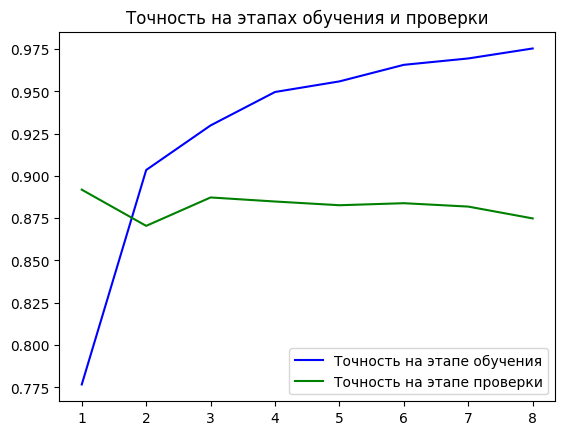

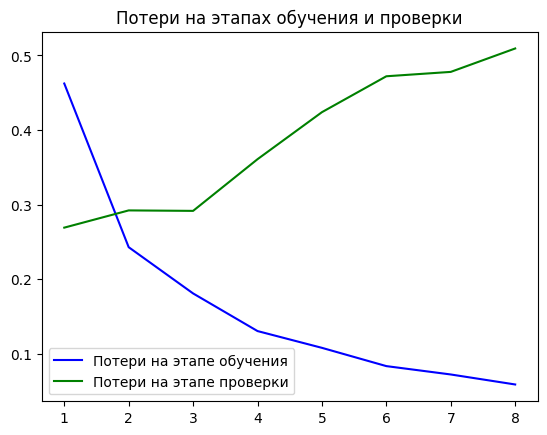

In [23]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "b", label="Точность на этапе обучения")
plt.plot(epochs, val_accuracy, "g", label="Точность на этапе проверки")
plt.title("Точность на этапах обучения и проверки")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "b", label="Потери на этапе обучения")
plt.plot(epochs, val_loss, "g", label="Потери на этапе проверки")
plt.title("Потери на этапах обучения и проверки")
plt.legend()
plt.show()

In [20]:
%load_ext tensorboard
%tensorboard --port=8000 --logdir=logs 
# http://localhost:8000/